<a href="https://colab.research.google.com/github/saahiljain/image-colorization-using-autoencoders-and-resnet/blob/master/kaggle_trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:


import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [3]:
cd /content/drive/My Drive/mudit-new-version1/

/content/drive/My Drive/mudit-new-version1


In [4]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
#added manually the dataset drive link by choosing "add to my drive" 
#!unzip  art-images-drawings-painting-sculpture-engraving.zip -d dataset/

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = '/content/drive/My Drive/mudit-new-version1/dataset/dataset/dataset_updated/training_set/painting'

train_ids = next(os.walk(TRAIN_PATH))[2]

In [5]:
X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|██████████| 2128/2128 [00:00<00:00, 2693.49it/s]


Total missing: 2128


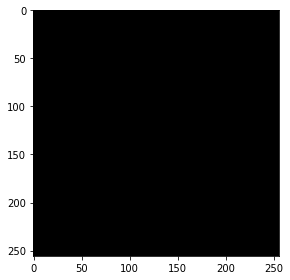

In [6]:
imshow(X_train[5])
plt.show()

In [0]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=seed)

In [0]:
#!wget 'https://github.com/fchollet/deep-learning-models/releases/download/v0.7/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5'

In [11]:
ls

art-images-drawings-painting-sculpture-engraving.zip
dataset/
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5


In [9]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('/content/drive/My Drive/mudit-new-version1/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

In [10]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 128 1280        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_5[0][0]            
__________________________________________________________________________________________

In [11]:
%%time

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

#Generate training data
def image_a_b_gen(dataset=X_train, batch_size = 20):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch
        


CPU times: user 183 µs, sys: 0 ns, total: 183 µs
Wall time: 187 µs


In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Art_Colorization_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

In [0]:
%%time
BATCH_SIZE = 20
model.fit_generator(image_a_b_gen(X_train,BATCH_SIZE),
            epochs=30,
            verbose=1,
            steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
             callbacks=model_callbacks
                   )



Epoch 1/30
102/101 [==============================] - 122s 1s/step - loss: 2.0544e-07
Epoch 2/30
102/101 [==============================] - 94s 925ms/step - loss: 5.9232e-10
Epoch 3/30
102/101 [==============================] - 103s 1s/step - loss: 2.3963e-10
Epoch 4/30
102/101 [==============================] - 103s 1s/step - loss: 1.5634e-10

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
102/101 [==============================] - 102s 1s/step - loss: 1.2822e-10
Epoch 6/30
102/101 [==============================] - 104s 1s/step - loss: 1.1496e-10
Epoch 7/30
 62/101 [=================>............] - ETA: 39s - loss: 1.0587e-10

In [0]:
model.save(filepath)
model.save_weights("Art_Colorization_Weights.h5")